In [1]:
from importlib import reload
import sys
from imp import reload
import warnings
warnings.filterwarnings('ignore')
if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Concatenate, Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /Users/jay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


เป็นการ import lib ที่ใช้ต่างๆ

In [2]:
import json
from typing import Dict, List


def read_jsonlines(file_path: str) -> List[Dict]:
    with open(file_path) as fp:
        return [json.loads(line) for line in fp.readlines()]


data = read_jsonlines("/Users/jay/Desktop/LimeSoda/dataset_train_wo_tokentags_v1/train_v1.jsonl")


เป็นฟังก์ชั่นการอ่านไฟล์ json โดยดึงข้อมูลจากไฟล์ train_v1.jsonl เข้ามาในตัวแปร data

In [3]:
import pandas as pd
import json
from pandas import json_normalize
df = json_normalize(data)
df['Text'] = df['Text'].str.join(" ")
df.head()

,Text,Document Tag
0,"เพื่อน ๆ รู้ ไหม ครับ ว่า "" การ ล้าง มือ ""...",Fact News
1,เทรนด์ กิ๊บเก๋ ... ป้องกัน โรค ||| ฮัดเช้ยยยย ...,Fact News
2,สถาน เอกอัครราชทูต คูเวต งด ออกวี ซ่า แก่ คน...,Fact News
3,"สั่ง ตรวจสอบ "" ลูก ตุ้ม พลังธาตุ "" ของขลัง ฆ่า...",Fact News
4,เรา ไม่ รู้ ว่า Covid - 19 กลัว ขิง กับ กัญชา ...,Fake News


แปลงข้อมูล json ให้อยู่ในรูปแบบ dataframe

In [4]:
df['Document Tag'].value_counts()

Fact News    1369
Fake News    1329
Name: Document Tag, dtype: int64

เป็นการแสดงจำนวนของ Document Tag

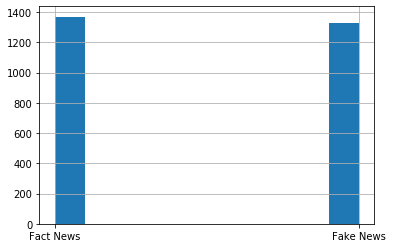

In [5]:
df['Document Tag'].hist()

โชว์กราฟจำนวนของ Document Tag

In [6]:
df['sentiment'] = df['Document Tag'].replace({'Fact News':0, 'Fake News':1})
df

,Text,Document Tag,sentiment
0,"เพื่อน ๆ รู้ ไหม ครับ ว่า "" การ ล้าง มือ ""...",Fact News,0
1,เทรนด์ กิ๊บเก๋ ... ป้องกัน โรค ||| ฮัดเช้ยยยย ...,Fact News,0
2,สถาน เอกอัครราชทูต คูเวต งด ออกวี ซ่า แก่ คน...,Fact News,0
3,"สั่ง ตรวจสอบ "" ลูก ตุ้ม พลังธาตุ "" ของขลัง ฆ่า...",Fact News,0
4,เรา ไม่ รู้ ว่า Covid - 19 กลัว ขิง กับ กัญชา ...,Fake News,1
...,...,...,...
2693,SaaPannisa ไข่ มุก นั้น ทำ มา จาก แป้ง มันสำปะ...,Fake News,1
2694,ออก กำลัง กาย ไล่ ความ ดัน โลหิต สูง ||| โดย ก...,Fact News,0
2695,‘ ผู้ ชาย - คน อ้วน ’ เสี่ยง ป่วย หนักหาก ติด ...,Fact News,0
2696,กระเทียม สุด ยอด ผัก จริง ๆ ตั้งแต่ ค . แข็ง ย...,Fake News,1


สร้าง sentiment มาใส่โดยถ้า Document Tag เป็น Fact News จะเท่ากับ 0 หากเป็น Fake News จะเท่ากับ 1

In [7]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(df['Text'])
RNN_CELL_SIZE = 32
MAX_LEN = 130   # Since our mean length is 128.5
X_train = pad_sequences(list_tokenized_train , maxlen=MAX_LEN)
y_train = df['sentiment']
print(y_train)



0       0
1       0
2       0
3       0
4       1
       ..
2693    1
2694    0
2695    0
2696    1
2697    0
Name: sentiment, Length: 2698, dtype: int64


เป็นเตรียมข้อมูลเพื่อมาทำการ train โดยจะแปลงจาก text  เป็น sequences

In [8]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights

สร้าง Attention modal เข้ามา

In [9]:
sequence_input = Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = Embedding(MAX_FEATURES, EMBED_SIZE)(sequence_input)

เป็นการสร้าง The Embedding Layer เข้ามา


In [10]:
lstm = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences = True), name="bi_lstm_0")(embedded_sequences)

# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(lstm)

เป็นการสร้าง Bi-LSTM modal เข้ามา

In [11]:
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

model = keras.Model(inputs=sequence_input, outputs=output)

In [12]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 130, 128)     768000      input_1[0][0]                    
__________________________________________________________________________________________________
bi_lstm_0 (Bidirectional)       (None, 130, 64)      41216       embedding[0][0]                  
__________________________________________________________________________________________________
bi_lstm_1 (Bidirectional)       [(None, 130, 64), (N 24832       bi_lstm_0[0][0]                  
______________________________________________________________________________________________

 output summary modal ที่สร้างมา

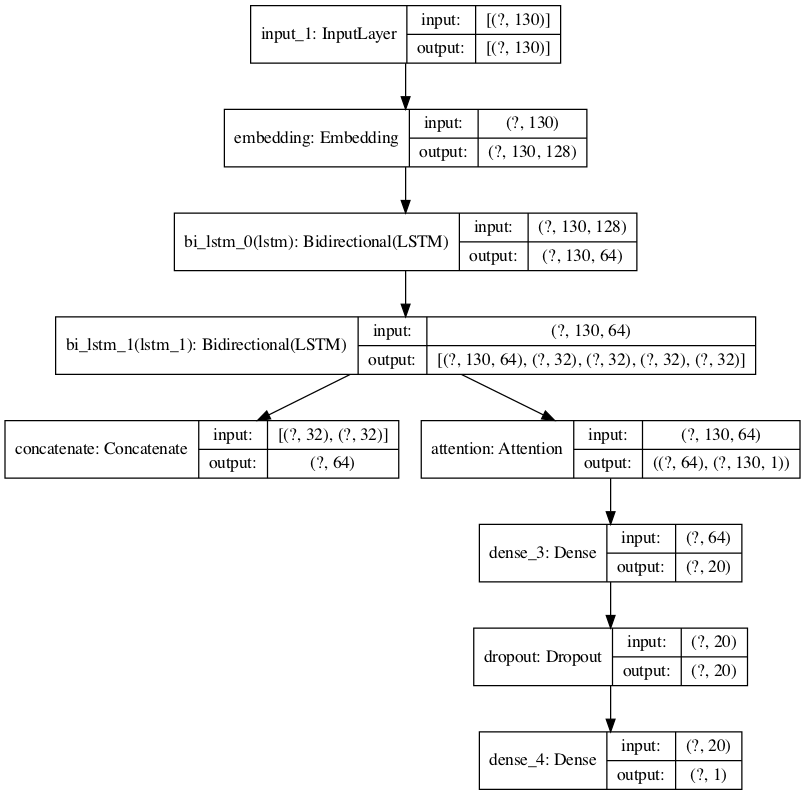

In [13]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=METRICS)

เป็นการกำหนดค่าให้แสดง  tp fp tn fn accuracy precision recall auc

In [15]:
import numpy as np
BATCH_SIZE = 100
EPOCHS = 5
X_train = np.array(X_train)
y_train = np.array(y_train)
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2)

Train on 2158 samples, validate on 540 samples
Epoch 1/5
2158/2158 [==============================] - 33s 15ms/sample - loss: 0.6537 - tp: 972.0000 - fp: 614.0000 - tn: 499.0000 - fn: 73.0000 - accuracy: 0.6816 - precision: 0.6129 - recall: 0.9301 - auc: 0.7744 - val_loss: 0.4965 - val_tp: 256.0000 - val_fp: 54.0000 - val_tn: 202.0000 - val_fn: 28.0000 - val_accuracy: 0.8481 - val_precision: 0.8258 - val_recall: 0.9014 - val_auc: 0.8782
Epoch 2/5
2158/2158 [==============================] - 22s 10ms/sample - loss: 0.3709 - tp: 910.0000 - fp: 165.0000 - tn: 948.0000 - fn: 135.0000 - accuracy: 0.8610 - precision: 0.8465 - recall: 0.8708 - auc: 0.9109 - val_loss: 0.3140 - val_tp: 262.0000 - val_fp: 47.0000 - val_tn: 209.0000 - val_fn: 22.0000 - val_accuracy: 0.8722 - val_precision: 0.8479 - val_recall: 0.9225 - val_auc: 0.9454
Epoch 3/5
2158/2158 [==============================] - 22s 10ms/sample - loss: 0.2366 - tp: 973.0000 - fp: 103.0000 - tn: 1010.0000 - fn: 72.0000 - accuracy: 0.9189

ทำการ train  จำนวน50รอบ

In [16]:
# Loading the test dataset, and repeating the processing steps 
datatest = read_jsonlines("/Users/jay/Desktop/LimeSoda/dataset_train_wo_tokentags_v1/val_v1.jsonl")
df2 = json_normalize(datatest)
df2['Text'] = df2['Text'].str.join(" ")
df2['sentiment'] = df2['Document Tag'].replace({'Fact News':0, 'Fake News':1,})
df2.head()

,Text,Document Tag,sentiment
0,เตือน ผู้ ปกครอง เฝ้า ระวัง อาการ แทรกซ้อน โรค...,Fact News,0
1,โรค ติด เชื้อ ไวรัส โคโรนา 2019 Coronavirus ...,Fact News,0
2,เปิดใจ ! สาว เจอ เมือกปริศนา ใน ช่อง คลอด ปัด ...,Fact News,0
3,# ค่า พีเอช คือ ความ เป็น ด่าง ที่ มี อยู่ ใน ...,Fake News,1
4,เรา กำลัง งง กับ คน ฮ่องกง ที่ มี ข่าว ว่า หน้...,Fake News,1


ดึงข้อมูลเพื่อนำมา test

In [17]:
MAX_FEATURES = 6000
EMBED_SIZE = 128
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(df2['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(df2['Text'])
RNN_CELL_SIZE = 32
MAX_LEN = 130   # Since our mean length is 128.5
X_test = pad_sequences(list_tokenized_train , maxlen=MAX_LEN)
y_test = df2['sentiment']

ทำการเตรียมข้อมูลเพื่อที่จะนำไปเทส

In [18]:
## Making predictions on our model
prediction = model.predict(X_test)
y_pred = (prediction > 0.5)

กำหนด prediction เพื่อใช้ในการแสดงผลทดสอบ

              precision    recall  f1-score   support

           0       0.61      0.62      0.61       152
           1       0.60      0.58      0.59       148

    accuracy                           0.60       300
   macro avg       0.60      0.60      0.60       300
weighted avg       0.60      0.60      0.60       300



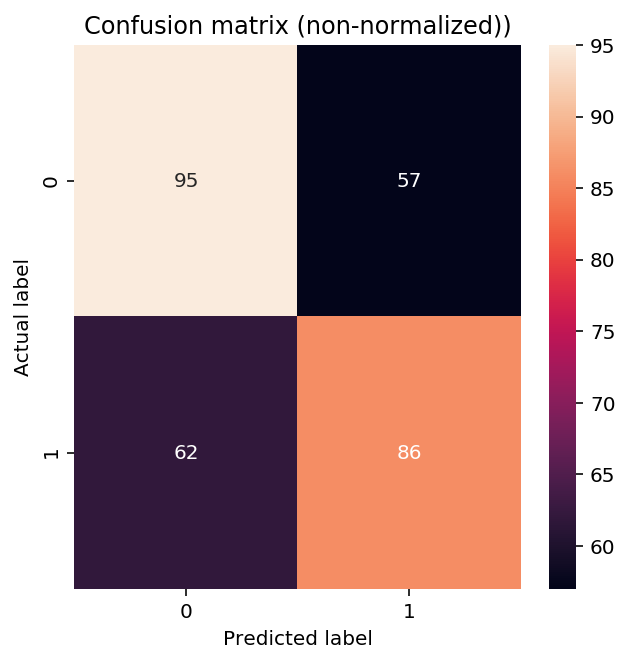

In [19]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report,
                             confusion_matrix,
                             roc_auc_score)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

report = classification_report(y_test, y_pred)
print(report)


def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

โชว์ผลลัพธ์ รวมถึงกราฟในการทดสอบ

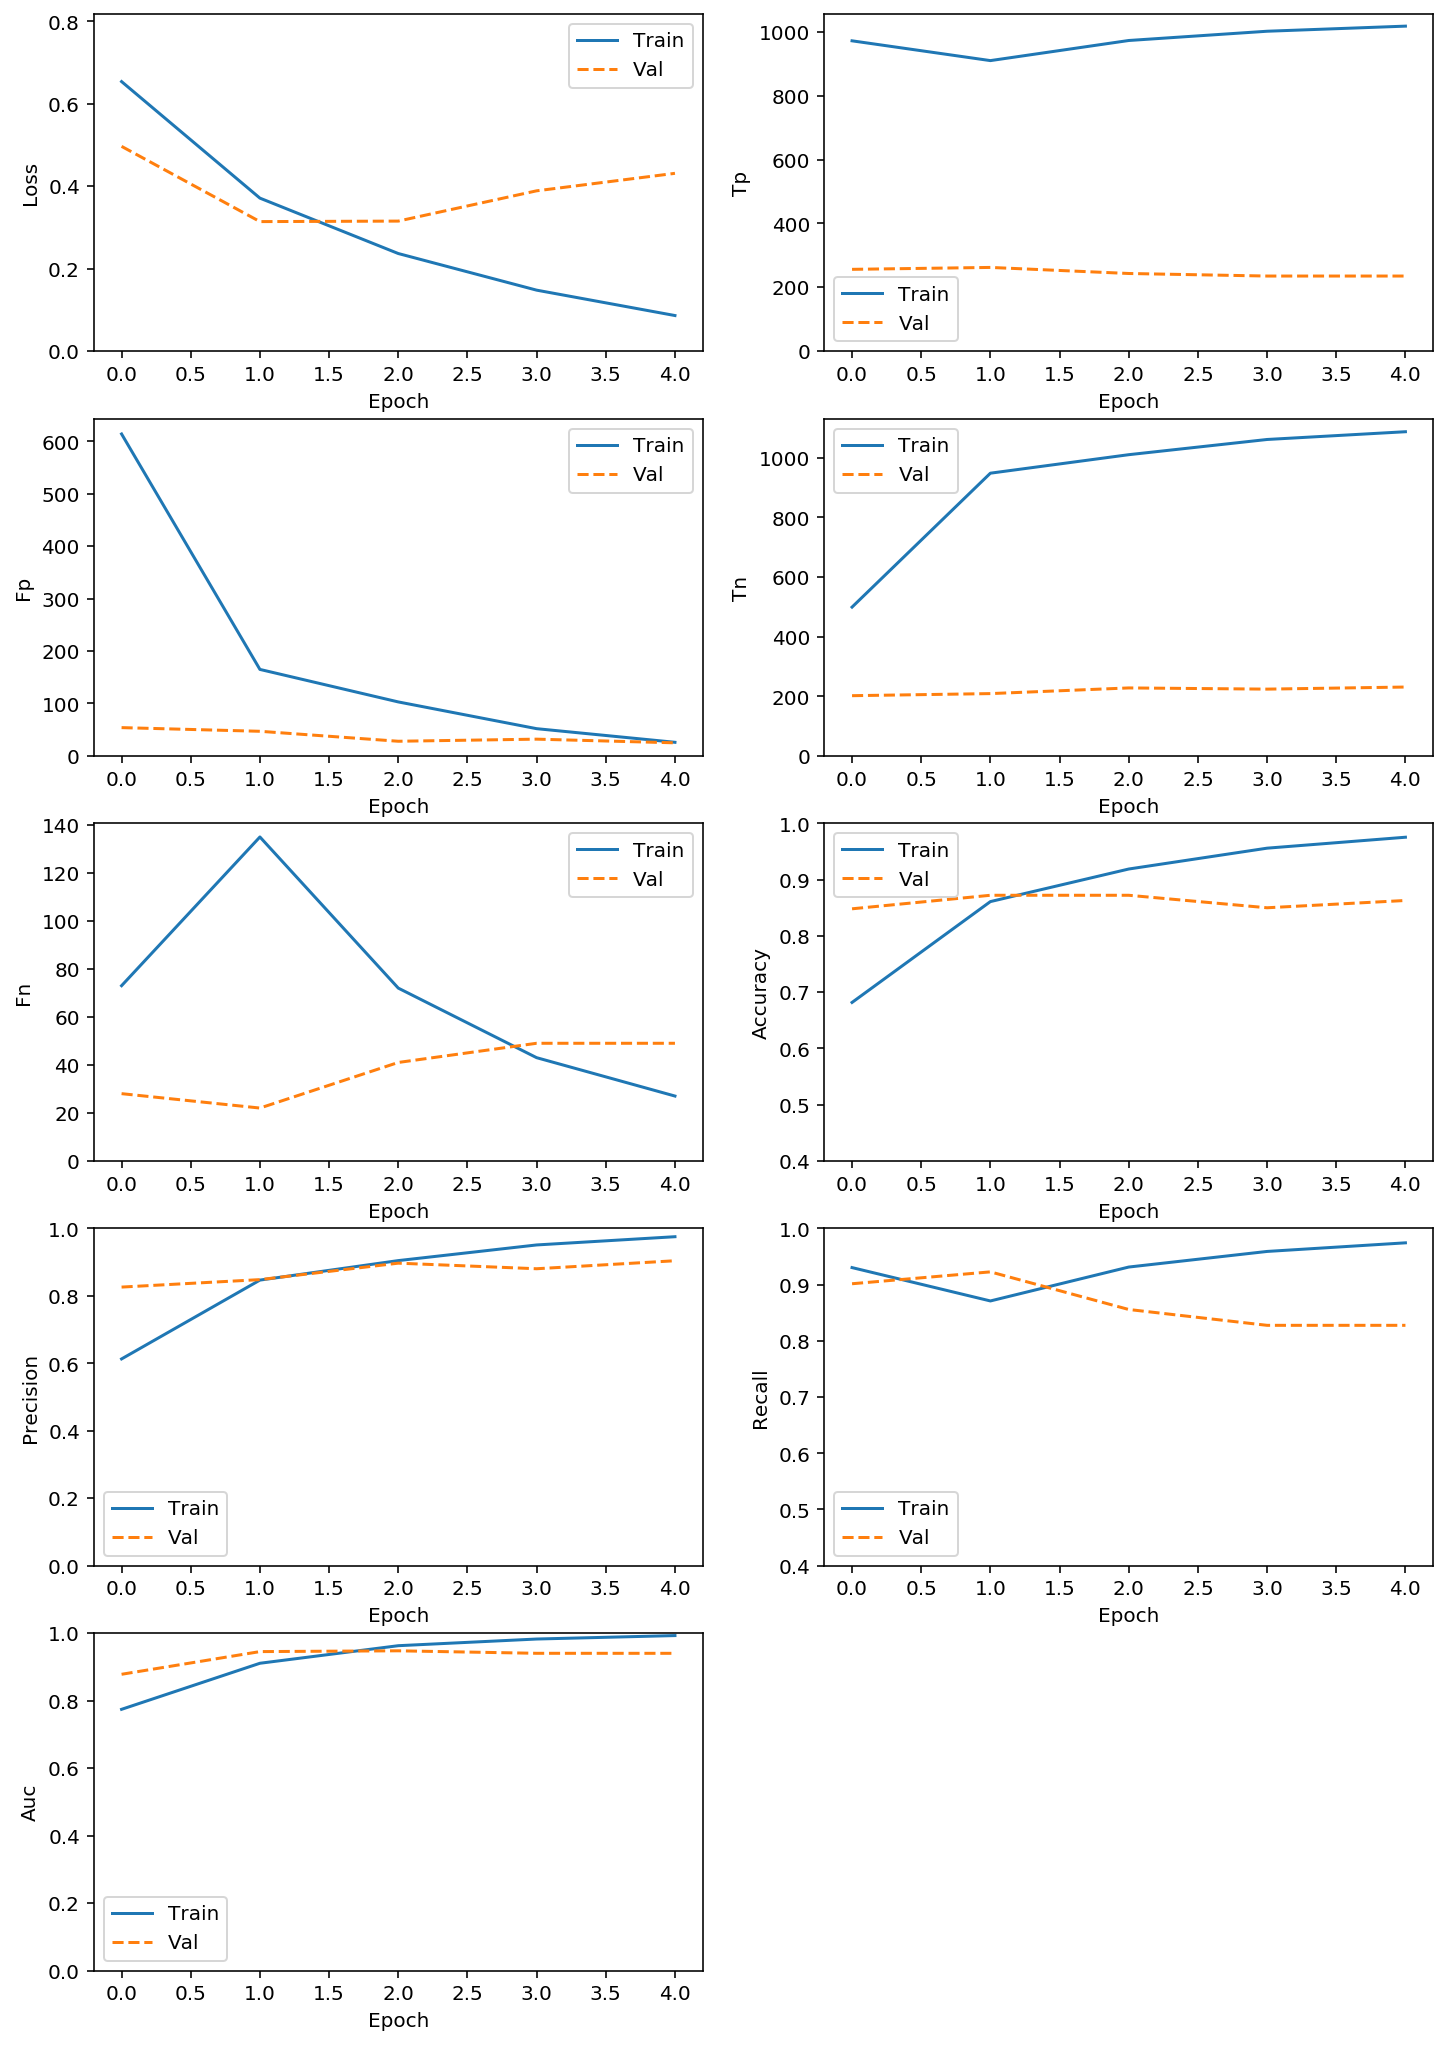

In [20]:
#plt.style.use("fivethirtyeight")

# Cross Validation Classification Accuracy

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
mpl.rcParams["figure.figsize"] = (12, 18)

def plot_metrics(history):
    metrics = [
        "loss",
        "tp", "fp", "tn", "fn",
        "accuracy",
        "precision", "recall",
        "auc",
    ]
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(5, 2, n + 1)
        plt.plot(
            history.epoch,
            history.history[metric],
            color=colors[0],
            label="Train",
        )
        plt.plot(
            history.epoch,
            history.history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1] * 1.2])
        elif metric == "accuracy":
            plt.ylim([0.4, 1])
        elif metric == "fn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "fp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tn":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "tp":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "precision":
            plt.ylim([0, 1])
        elif metric == "recall":
            plt.ylim([0.4, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

plot_metrics(history)